In [97]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

In [98]:
from sklearn.preprocessing import scale

In [99]:
from tqdm import tqdm_notebook as tqdm

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

In [101]:
from sklearn.utils import shuffle
from scipy.special import softmax

In [102]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [103]:
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = True

In [104]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

# All mixture of expert model

In [105]:
class TorchDataset(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TorchDataset, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [106]:
class HyperModelNN(nn.Module):
    def __init__(self, input_dim = 20, hidden_dim = 10, output_dim = 10, device = 'cpu'):
        super(HyperModelNN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        self.optimizer = torch.optim.Adam(self.parameters())
        
        self.to(device)
        
    def forward(self, input):
        out = input
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def E_step(self, X, Y, Z, HyperParameters):
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        dataset = TorchDataset(X, Z, device = self.device)
        
        for _ in range(10):
            train_generator = DataLoader(dataset = dataset, batch_size = 16, shuffle=True)
            for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
                self.zero_grad()
                loss = -(torch.nn.functional.log_softmax(self.forward(batch_of_x), dim = -1)*batch_of_y).sum()
                loss.backward()
                self.optimizer.step()
        pass
        

In [107]:
class NoiseModelLinear:
    def __init__(self, input_dim = 20, device = 'cpu'):
        self.input_dim = input_dim
        self.device = device
        
        self.W = torch.zeros(input_dim, 1, device = self.device)
        
    def forward(self, input):
        return torch.randn([input.shape[0], 1])
     
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            return (temp1*Z).mean().detach()
        return 0
    
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        return (-0.5*beta*(temp1) + 0.5*np.log(beta/(2*np.pi))).detach()
        
    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass

In [158]:
class EachModelLinear:
    def __init__(self, input_dim = 20, device = 'cpu', a = None, w = None):
        self.input_dim = input_dim
        self.device = device
        
        self.a = a
        self.w_0 = w
            
        self.W = torch.randn(input_dim, 1, device = self.device)
        
        if w is not None:
            self.W = w.detach()
        
        self.B = torch.eye(input_dim, device = self.device)

        
    def forward(self, input):
        return input@self.W
    
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            temp2 = -2*Y*(X@self.W)
            temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
            return ((temp1 + temp2 + temp3)*Z).mean().detach()
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        temp2 = -2*Y*(X@self.W)
        temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
        return (-0.5*beta*(temp1 + temp2 + temp3) + 0.5*np.log(beta/(2*np.pi))).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        if self.a is None:
            self.B = torch.inverse(((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])
            self.W.data = (self.B@second).view_as(self.W).detach()
        else:
            self.B = torch.inverse(torch.diag(1/self.a) + beta*((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])       
            if self.w_0 is None:
                self.W.data = (beta*(self.B@second)).view_as(self.W).detach()
            else:
                self.W.data = (self.B@(beta*second + torch.diag(1/self.a)@self.w_0)).view_as(self.W).detach()
        
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        if self.a is not None:
            if self.w_0 is not None:
                self.a = torch.diagonal(self.B+self.W@self.W.transpose(0,1) - 2*self.w_0@self.W.transpose(0,1) + self.w_0@self.w_0.transpose(0,1)).detach()
            else:
                self.a = torch.diagonal(self.B+self.W@self.W.transpose(0,1)).detach()
        if self.w_0 is not None:
            self.w_0 = self.W.detach()

        return


In [109]:
class MixtureExpert:
    def __init__(self, input_dim = 10, K = 2, HyperParameters = {'beta': 1}, HyperModel = None, ListOfModels = None, device = 'cpu'):
        """
        It's necessary! The Hyper Parameter should be additive to models.
        """
        
        self.K = K
        self.n = input_dim
        self.device = device
        
        self.HyperParameters = HyperParameters
        
        if HyperModel is None:
            self.HyperModel = HyperModelNN(input_dim = input_dim, hidden_dim = 10, output_dim = K, device = device)
        else:
            self.HyperModel = HyperModel
            
        if ListOfModels is None:
            self.ListOfModels = [EachModelLinear(input_dim = input_dim, device = device) for _ in range(K)]
        else:
            self.ListOfModels = ListOfModels
        
        self.pZ = None
        return
        
    def E_step(self, X, Y):
# Optimize Z
        temp1 = 0#torch.nn.functional.log_softmax(self.HyperModel(X), dim = -1)
        temp2 = torch.cat([self.ListOfModels[k].LogLikeLihoodExpectation(X, Y, self.HyperParameters) for k in range(self.K)], dim = 1)
        self.pZ = torch.nn.functional.softmax(temp1 + temp2, dim=-1).detach()
    
# Optimize each model
        for k in range(self.K):
            self.ListOfModels[k].E_step(X, Y, self.pZ[:,k].view([-1, 1]), self.HyperParameters)
            
# Optimize HyperModel
        self.HyperModel.E_step(X, Y, self.pZ, self.HyperParameters)
        return
        
    def M_step(self, X, Y):
# Optimize EachModel
        for k in range(self.K):
            self.ListOfModels[k].M_step(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters)
            
# Optimize HyperParameters
        for Parameter in self.HyperParameters:
            temp = 0
            for k in range(self.K):
                temp += self.ListOfModels[k].OptimizeHyperParameters(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters, Parameter)
            self.HyperParameters[Parameter] = temp.detach()
        
# Optimize HyperModel
        self.HyperModel.M_step(X, Y, self.pZ, self.HyperParameters)
        return
                
    def fit(self, X = None, Y = None, epoch = 10, progress = None):
        """
        X has a shape [N x n]
        Y has a shape [n x p]
        """
        if X is None:
            return None
        if y is None:
            return None
        
        iterations = range(epoch)
        
        if progress is not None:
            iterations = progress(iterations)
        
        for _ in iterations:
            self.E_step(X, Y)
            self.M_step(X, Y)
            
        return
    
    def predict(self, X):
        """
        X has a shape [N x n]
        """
        pi = torch.nn.functional.softmax(self.HyperModel(X), dim = -1).detach()
        answ = torch.cat([self.ListOfModels[k](X) for k in range(self.K)], dim = 1).detach()
        
        return (answ*pi).sum(dim = -1).data.numpy()
    

# Experiment

## Create Data

In [14]:
from PIL import Image

In [15]:
from PIL import ImageDraw

In [16]:
# image = Image.fromarray(np.zeros([255, 255], dtype = np.int8))

# draw = ImageDraw.Draw(image)

# x0, y0, x1, y1 = [20, 20, 230, 230]
# draw.ellipse([x0, y0, x1, y1], fill = 1)
# draw.ellipse([x0+1, y0+1, x1-1, y1-1], fill = 0)

# k = 70
# draw.ellipse([x0+k, y0+k, x1-k, y1-k], fill = 1)
# draw.ellipse([x0+1+k, y0+1+k, x1-1-k, y1-1-k], fill = 0)

In [17]:
# img = np.array(image)
# img = (img*np.random.choice([0,1], size=img.shape, p = [0.1, 0.9])+np.random.choice([0,1], size=img.shape, p = [0.995, 0.005])) > 0


In [18]:
# image = Image.fromarray(np.array(img, dtype = np.int8))

In [19]:
# plt.matshow(image)

In [110]:
# image = Image.open('Picture/3_mask.jpg').convert('L')

# image = Image.fromarray((255*(np.array(image) < 125)).astype(np.uint8))

# plt.matshow(image)

In [111]:
# x = np.where(np.array(image) > 0)[1]
# # x = x/255
# # x = x - x.mean()
# y = image.size[0]-np.where(np.array(image) > 0)[0]
# # y = y/255
# # y = y - y.mean()

In [45]:
# x = scale(x)
# y = scale(y)

In [112]:
# plt.plot(x, y, '.')

In [119]:
N = 500
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

# x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0, 4*(np.random.rand(500)-0.5) + x0])
x += 0.1*np.random.randn(x.shape[0])
# y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0, 4*(np.random.rand(500)-0.5) + y0])
y += 0.1*np.random.randn(y.shape[0])


In [120]:
X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([1500, 3]), torch.Size([1500, 1]))

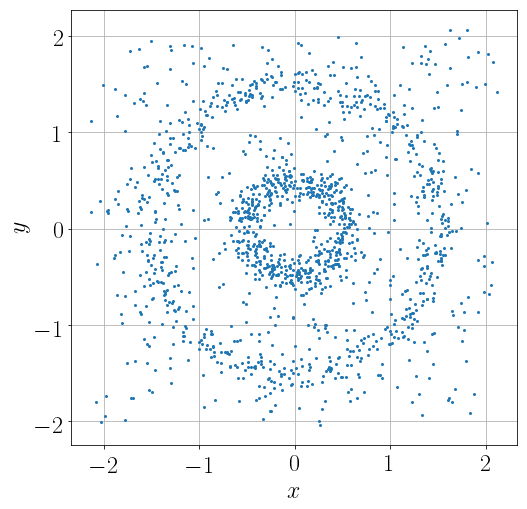

In [121]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

_ = plt.plot(x, y, '.')

plt.xlabel('$x$')
plt.ylabel('$y$')

# plt.savefig('./results/statment_3.pdf', bbox_inches='tight')

plt.grid()
plt.show()

## Statment picture

In [122]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

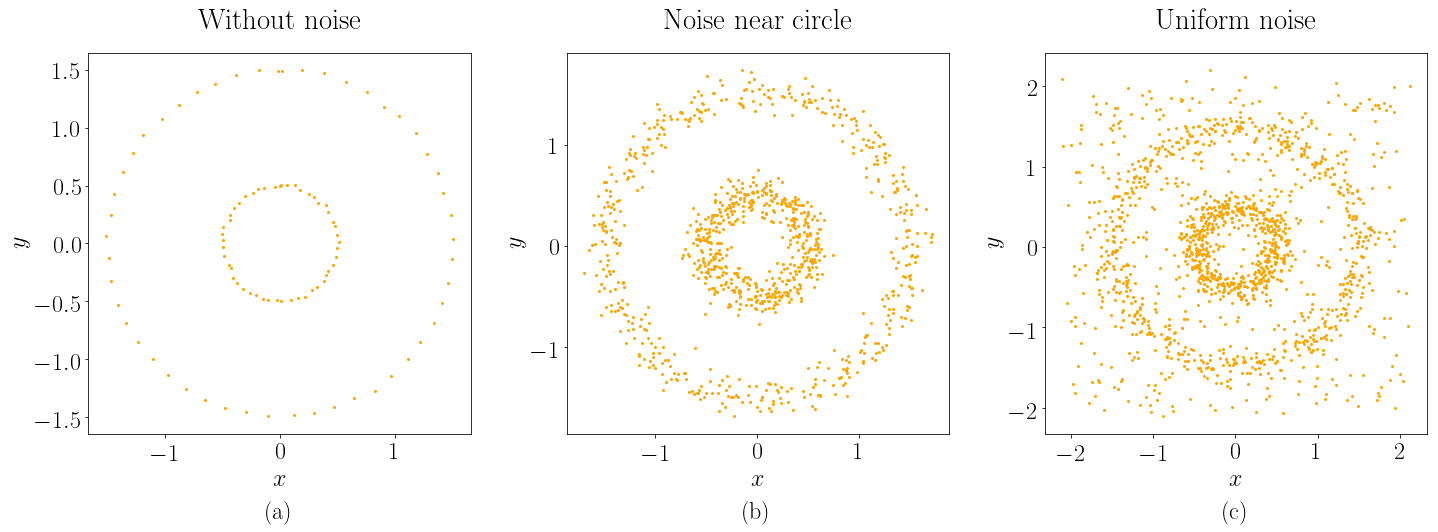

In [167]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 7.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']


fig = plt.figure();

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax1 = [] 
for k in range(3):
    ax1.append(fig.add_subplot(gs[k]))
    
cols = ['Without noise', 'Noise near circle', 'Uniform noise']

TITLE = ['(a)', '(b)', '(c)']

#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    
    ax1[k].annotate(cols[k], xy=(0.5, 1), xytext=(0, 24),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

    ax1[k].set_xlabel('$x$')
    ax1[k].set_ylabel('$y$')
    
    _ = ax1[k].plot(x, y, '.', color = colors[0], label = 'model '+str(i))
    ax1[k].set_title(TITLE[k], y=-0.24)
        


plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./results/statment.pdf', bbox_inches='tight')

plt.show()

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [62]:
LIST_A = [torch.Tensor([1, 1, 1]), torch.Tensor([1, 1, 1])]
LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [2]])]

K = 2
LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
#     LoM.append(EachModelLinear(input_dim = n, device = device, a = torch.ones(3)*LIST_A[k]))
    LoM.append(EachModelLinear(input_dim = n, device = device, a = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

K += 1
LoM.append(NoiseModelLinear(input_dim = n))

HypPar = {'beta': 1}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


In [63]:
print(LoM[0].a)
print(LoM[1].a)

tensor([1., 1., 1.])
tensor([1., 1., 1.])


In [64]:
%%time
model.fit(X_tr, Y_tr, 1, progress = tqdm)


CPU times: user 1.29 s, sys: 55 ms, total: 1.34 s
Wall time: 1.28 s


In [65]:
print(LoM[0].a)
print(LoM[1].a)

tensor([0.0012, 0.0013, 0.6275])
tensor([0.0338, 0.0586, 0.2287])


In [66]:
model.HyperParameters

{'beta': tensor(1.8452)}

In [67]:
((model.predict(X_tr)-Y_tr)**2).mean()

tensor(3.2463)

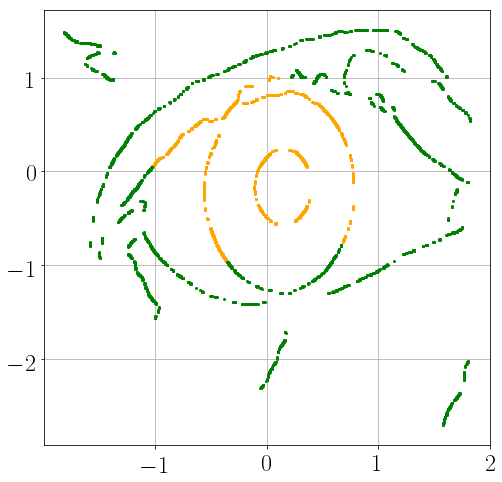

In [68]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [69]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-0.02734378, -0.02970456,  0.8916849 ],
       [ 0.18367937, -0.24200194,  2.4779105 ]], dtype=float32)

In [70]:

CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = param[:2]
    r = (param[2] + param[1]**2 + param[0]**2)**0.5
    CIRCLE[i] = param[0], param[1], r
    
CIRCLE

array([[-0.02734378, -0.02970456,  0.9451534 ],
       [ 0.18367937, -0.24200194,  1.6031885 ]], dtype=float32)

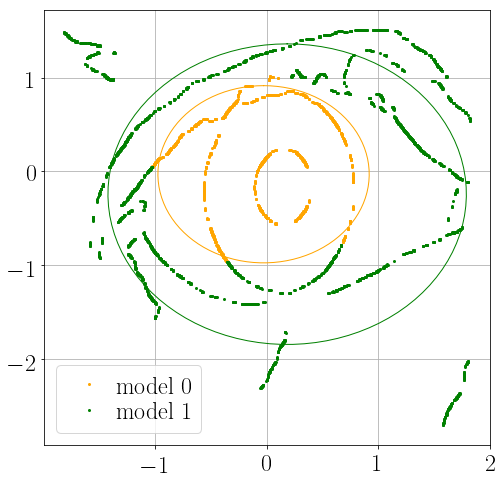

In [71]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

# plt.savefig('results/full_infomative.pdf', )

plt.show()

## Computation experiment

In [128]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

In [129]:
List_of_Data_Prior = []
List_of_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])

    LIST_A = [torch.Tensor([1, 1, 1]), torch.Tensor([1, 1, 1])]
    LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [5]])]

    K = 2
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device, a = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

    HypPar = {'beta': 1}
    HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

    model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, 50, progress = tqdm)

    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    List_of_Data_Prior.append(idx)
    List_of_Prior_model.append(model)



In [134]:
List_of_Data_Non_Prior = []
List_of_Non_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    
    K = 2
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device))

    HypPar = {'beta': 1}
    HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

    model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, 50, progress = tqdm)

    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    List_of_Data_Non_Prior.append(idx)
    List_of_Non_Prior_model.append(model)


In [159]:
x, y = List_of_Data[1]
X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

K = 2
LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1}
HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
model.fit(X_tr, Y_tr, 50, progress = tqdm)

idx = np.argmax(model.pZ.data.numpy(), axis = 1)

In [160]:
List_of_Data_Non_Prior[1] = idx
List_of_Non_Prior_model[1] = model

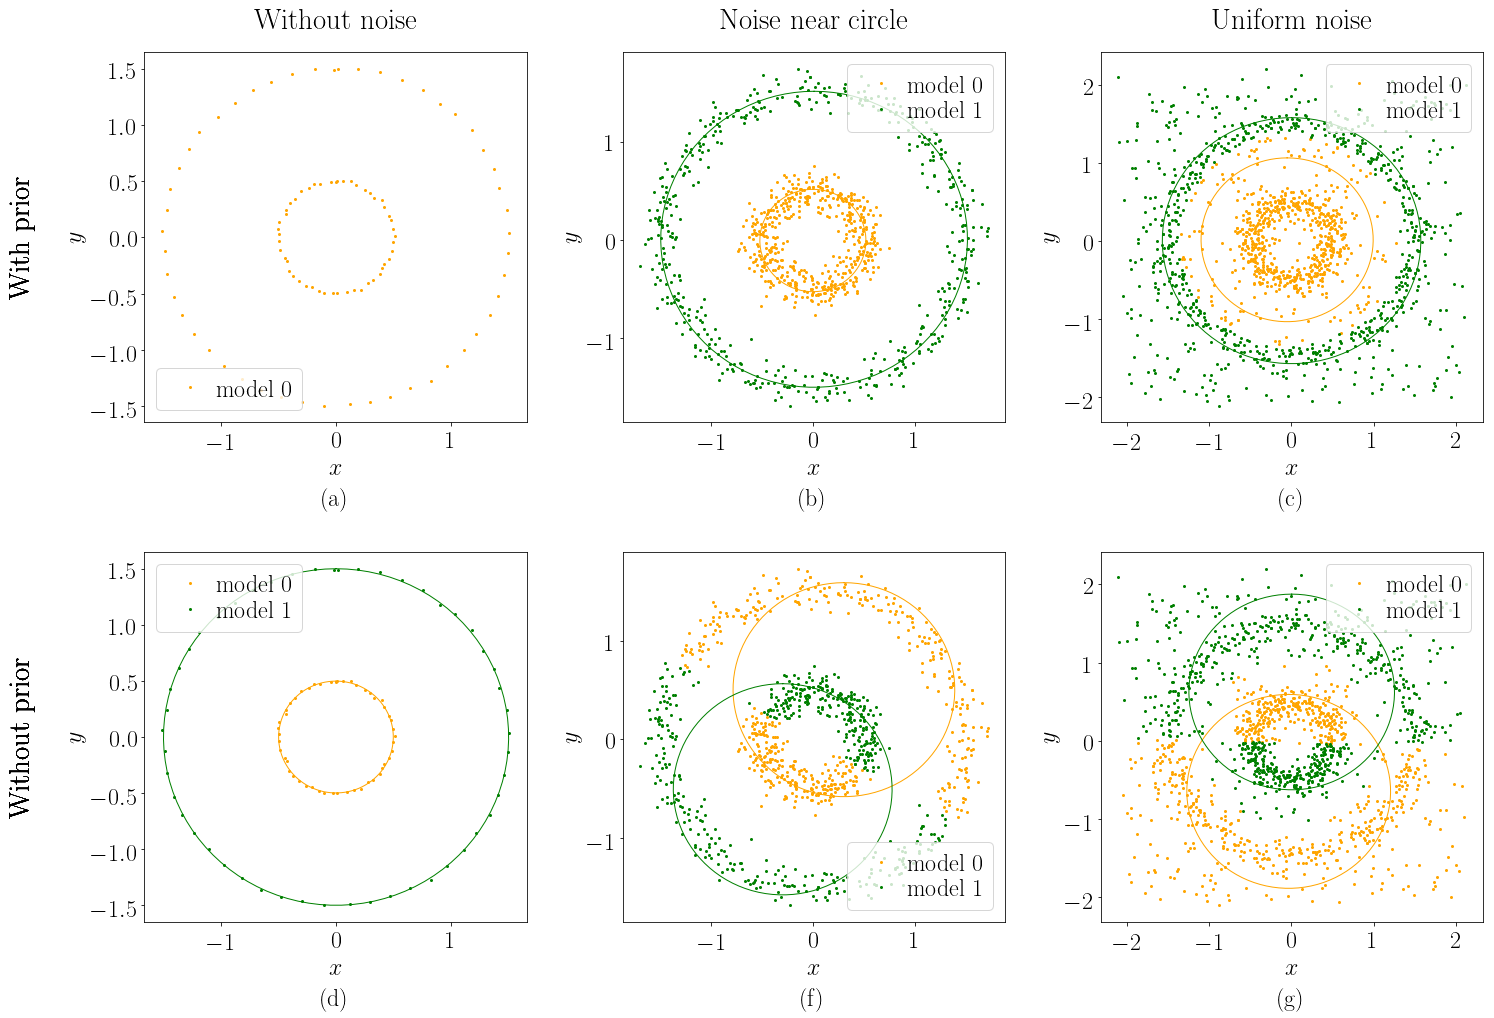

In [168]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']




fig = plt.figure();

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])

ax1 = [] 
for k in range(3):
    ax1.append(fig.add_subplot(gs[k]))
    
ax2 = [] 
for k in range(3, 6):
    ax2.append(fig.add_subplot(gs[k]))
    
cols = ['Without noise', 'Noise near circle', 'Uniform noise']

TITLE = ['(a)', '(b)', '(c)']
    
#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Prior[k]
    
    model = List_of_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)
    
    ax1[k].annotate(cols[k], xy=(0.5, 1), xytext=(0, 24),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

    ax1[k].set_xlabel('$x$')
    ax1[k].set_ylabel('$y$')
    
    for i, param in enumerate(TEMP):
        x0, y0 = param[:2]
        r = (param[2] + param[1]**2 + param[0]**2)**0.5
        CIRCLE[i] = param[0], param[1], r

    for i in np.unique(idx):
        _ = ax1[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax1[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax1[k].legend(loc = 'best')
        
        ax1[k].set_title(TITLE[k], y=-0.24)
        
        ax1[0].annotate('With prior', xy=(0, 0.5), xytext=(-ax1[0].yaxis.labelpad - 24, 0),
                        xycoords=ax1[0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
        
TITLE = ['(d)', '(f)', '(g)']
        
#------___2___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Non_Prior[k]
    
    model = List_of_Non_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)
    
    ax2[k].set_xlabel('$x$')
    ax2[k].set_ylabel('$y$')

    for i, param in enumerate(TEMP):
        x0, y0 = param[:2]
        r = (param[2] + param[1]**2 + param[0]**2)**0.5
        CIRCLE[i] = param[0], param[1], r

    for i in np.unique(idx):
        _ = ax2[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax2[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax2[k].legend(loc = 'best')
        ax2[k].set_title(TITLE[k], y=-0.24)
    
        ax2[0].annotate('Without prior', xy=(0, 0.5), xytext=(-ax2[0].yaxis.labelpad - 24, 0),
                        xycoords=ax2[0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
    
# plt.grid()

plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./results/experiment_sintetick.pdf', bbox_inches='tight')

plt.show()